In [187]:
import networkx as nx

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as itr
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

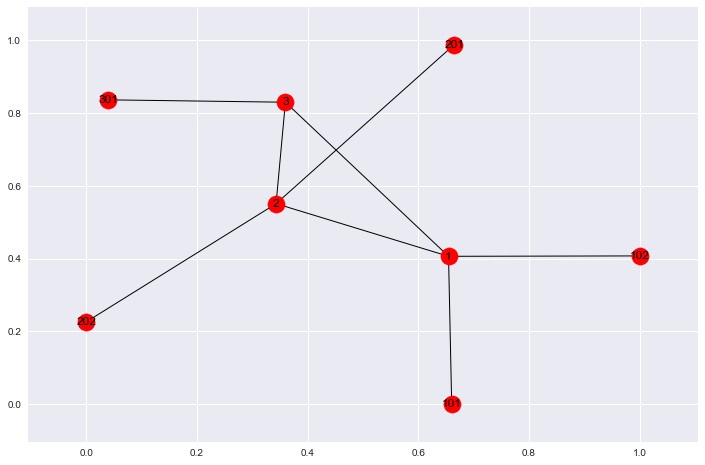

In [189]:
num_of_hub = 3
exp_spoke = 2
num_of_spoke = np.random.normal(exp_spoke,1,num_of_hub)
num_of_spoke = list(map(round, num_of_spoke))
hub = list(range(1,num_of_hub+1))

nw = nx.Graph()
nw.add_nodes_from(hub, label = "Hub")
hub_edges = np.array(list(itr.combinations(hub,2)))
nw.add_edges_from(hub_edges, label = "Hub_edges")

for i, h in enumerate(hub):
    num_of_s = int(num_of_spoke[i])
    spokes = [(h*100 + a) for a in range(1,num_of_s+1)]
    nw.add_nodes_from(spokes, label = "spokes of hub " + str(h) )
    edge_to_hub = [(h, s) for s in spokes ]
    nw.add_edges_from(edge_to_hub, label = "Spoke_edges" )
    
plt.figure(figsize = (12,8))
nx.draw_networkx(nw)
plt.show()

In [190]:
itin = np.array(list(itr.combinations(nx.nodes(nw),2)))

In [191]:
import pandas as pd
df_itin = pd.DataFrame({'itinenary': list(map(tuple, itin))})
df_itin.head(5)

,itinenary
0,"(1, 2)"
1,"(1, 3)"
2,"(1, 101)"
3,"(1, 102)"
4,"(1, 201)"


In [192]:
def clr(tup):
    a = tup[0]
    b = tup[1]
    if (a < 100 and b>= 100) or (a >= 100 and b < 100):
        return 'spoke-hub'
    elif a < 100 and b < 100:
        return 'hub-hub'
    elif a >= 100 and b >= 100:
        return 'spoke-spoke'

In [193]:
itin_type = list(map(clr, df_itin['itinenary']))
df_itin['type'] = itin_type

In [194]:
def path_len(G, tup):
    a = tup[0]
    b = tup[1]
    return nx.shortest_path_length(G,a,b)

paths = list(map(lambda x: path_len(nw, x), df_itin['itinenary']))

In [195]:
df_itin['length'] = paths

In [196]:
def price(row):
    #hub to spoke
    h_s_mean = 0.7
    h_s_var = 0.08
    
    #spoke to hub to spoke
    s_h1_s_mean = 0.9
    s_h1_s_var = 0.08
    
    #hub to hub
    h_h_mean = 1.0
    h_h_var = 0.1

    #hub to hub to spoke
    h_h_s_mean = 1.3
    h_h_s_var = 0.1
    
    #spoke to hub to hub to spoke
    s_h2_s_mean = 1.5
    s_h2_s_var = 0.1
     
    
    if row[1] == 'hub-hub':
        return np.random.lognormal(h_h_mean, h_h_var)*100
    elif row[2] == 2 and row[1] == 'spoke-spoke':
        return np.random.lognormal(s_h1_s_mean, s_h1_s_var)*100
    elif row[2] == 2 and row[1] == 'spoke-hub':
        return np.random.lognormal(h_h_s_mean, h_h_s_var)*100
    elif row[1] == 'spoke-hub':
        return np.random.lognormal(h_s_mean, h_s_var)*100
    elif row[2] == 3:
        return np.random.lognormal(s_h2_s_mean, s_h2_s_var)*100
    
    

In [197]:
df_itin['fare1'] = df_itin.apply(price, axis = 1)

In [198]:
s_h2_s = df_itin[df_itin.type == 'spoke-spoke'][df_itin.length == 3].fare1.mean()
s_h1_s = df_itin[df_itin.type == 'spoke-spoke'][df_itin.length == 2].fare1.mean()
h_s = df_itin[df_itin.type == 'spoke-hub'][df_itin.length == 1].fare1.mean()
h_h_s = df_itin[df_itin.type == 'spoke-hub'][df_itin.length == 2].fare1.mean()
h_h = df_itin[(df_itin.type == 'hub-hub')].fare1.mean()

print('The average fare (class1) of a hub to spoke is ', round(h_s, 2))
print('The average fare (class1) of a spoke to hub to spoke is ', round(s_h1_s, 2))
print('The average fare (class1) of a hub to hub is ', round(h_h, 2))
print('The average fare (class1) of a hub to hub to spoke is ', round(h_h_s, 2))
print('The average fare (class1) of a spoke to hub to hub to spoke is ', round(s_h2_s, 2))



The average fare (class1) of a hub to spoke is  197.9
The average fare (class1) of a spoke to hub to spoke is  255.49
The average fare (class1) of a hub to hub is  243.4
The average fare (class1) of a hub to hub to spoke is  364.01
The average fare (class1) of a spoke to hub to hub to spoke is  475.49


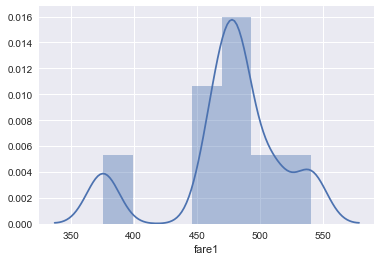

In [199]:
sns.distplot(df_itin[df_itin.type == 'spoke-spoke'][df_itin.length == 3].fare1)

In [ ]:
## df_itin['fare2'] = df_itin['fare1']*1.5
df_itin['fare3'] = df_itin['fare1']*2.5

df_fare = df_itin[['fare1', 'fare2', 'fare3']]
df_itin.head(5)

In [446]:
## constructing leg-itinenary matrix
itin_path = df_itin.itinenary

df_leg = df_itin[df_itin.length == 1]
df_leg.reset_index(drop = True, inplace = True)
df_leg.rename(columns = {'itinenary': 'leg'}, inplace = True)

leg_path = df_leg.leg

cap_mean = 0.8
cap_var = 0.2

def rand_cap(s):
    if s == 'hub-hub':
        return int(round(np.random.lognormal(cap_mean*1.15, cap_var*1.2)))
    else:
        return int(round(np.random.lognormal(cap_mean, cap_var)))

df_leg['capacity'] = list(map(rand_cap, df_leg.type ))

df_leg.head(5)

,leg,type,length,fare1,fare2,fare3,capacity
0,"(1, 2)",hub-hub,1,243.437466,365.156200,608.593666,3
1,"(1, 3)",hub-hub,1,232.575644,348.863466,581.439110,5
2,"(1, 101)",spoke-hub,1,197.321841,295.982761,493.304602,2
3,"(1, 102)",spoke-hub,1,223.106697,334.660045,557.766742,3
4,"(2, 3)",hub-hub,1,254.175125,381.262688,635.437813,3


In [447]:
test = itin_path[6]
def leg_in_itin(itin, legs):
    a = itin[0]
    b = itin[1]
    
    short_paths = nx.shortest_path(nw, a, b)
    l1 = []
    for i in range(len(short_paths) -1 ):
        l1.append((short_paths[i],short_paths[i+1]))
        
    e = [0]*len(legs)
    for j in l1:
        e += (j == legs)*1

    return e


#leg_in_itin(itin_path[0], leg_path)
def E_df(leg_path, itin_path):
    m = np.matrix(list(map(lambda x: leg_in_itin(x, leg_path), itin_path)))
    df = pd.DataFrame(m, index = itin_path, columns = leg_path)
    return df
df_e = E_df(leg_path, itin_path)
df_full = pd.concat([df_itin, df_e.reset_index(drop = True)], axis = 1)
df_full.head(5)

,itinenary,type,length,fare1,fare2,fare3,"(1, 2)","(1, 3)","(1, 101)","(1, 102)","(2, 3)","(2, 201)","(2, 202)","(3, 301)"
0,"(1, 2)",hub-hub,1,243.437466,365.156200,608.593666,1,0,0,0,0,0,0,0
1,"(1, 3)",hub-hub,1,232.575644,348.863466,581.439110,0,1,0,0,0,0,0,0
2,"(1, 101)",spoke-hub,1,197.321841,295.982761,493.304602,0,0,1,0,0,0,0,0
3,"(1, 102)",spoke-hub,1,223.106697,334.660045,557.766742,0,0,0,1,0,0,0,0
4,"(1, 201)",spoke-hub,2,365.768236,548.652354,914.420590,1,0,0,0,0,1,0,0


## Linear Program

\begin{equation*}
Maximize
\sum_{t \ \in \ T} 
\sum_{k \ \in \ K}
\sum_{j \ \in \ J}
f_{jk} \  
w_{jkt}
\end{equation*}

\begin{equation*}
Subject\ to:\ C_i - 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
 \\ + 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t - L)
(1-p)(1-\pi)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
\geq 0
\, 
\forall \ i \ \in \ N
\ ,
\forall \ t \ \in \ T
\\
w_{jkt} 
\leq
\lambda_{jkt}
\end{equation*}

In [535]:
num_of_time = 10
num_of_class = 3
num_of_itin = len(itin_path)
num_of_leg = len(leg_path)

T = list(range(num_of_time))
K = list(range(num_of_class))
J = list(range(num_of_itin))
N = list(range(num_of_leg))

## Time to lock
L = 3

## E[j][i] = 1 if leg i is in itinenary j
E = np.array(df_e)

## C[i]: Capacity remained on leg i
C = list(df_leg.capacity)

## p: Probability that a customer purchased a ticket directly
## 1 - p: Probability that a customer locked a ticket
p = 0.5

#pi : Prabability that a customer finally bought the ticket that he locked
pi = 0.4

#R[j][k]: fare of itinenary j with fare class k
R = np.matrix(df_fare)

#u: fee for fare-locking
u = 20

## F[j][k]: expected revenue from itinenary j with fare class k
F = np.array(p*R + (1 - p)*(u + pi*R))

##lmd[j][k][t]: Probability of a customer interest in itinenary j with fare-class k at time t
lmd = [[np.random.uniform(0.2, 1, num_of_time) for i in K] for j in J]

##Decision function
def one(a):
    if a:
        return 1
    else: 
        return 0

In [536]:
from gurobipy import *

In [537]:
model = Model("network")

## create decision variables 
W = [[[ 0 for t in T] for k in K ] for j in J]

for t in T:
    for k in K:
        for j in J:
            W[j][k][t] = model.addVar( vtype = GRB.CONTINUOUS, 
                                        name = "W_" + str(j) + "_" + str(k) + "_" + str(t))
            
model.update()

\begin{equation*}
Maximize
\sum_{t \ \in \ T} 
\sum_{k \ \in \ K}
\sum_{j \ \in \ J}
f_{jk} \  
w_{jkt}
\end{equation*}


In [538]:
## create a linear expression of the objective 
objExpr = LinExpr()
for t in T:
    for k in K:
        for j in J:
            objExpr += F[j][k] * W[j][k][t]
model.setObjective(objExpr, GRB.MAXIMIZE)

\begin{equation*}
\ C_i - 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
+ 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t - L)
(1-p)(1-\pi)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
\geq 0
\ , 
\forall \ i \ \in \ N
\ ,
\forall \ t \ \in \ T
\end{equation*}


In [539]:
## create constraints for capacity
for t in T:
    for i in N:
        constExpr = LinExpr()
        for s in T:
            for k in K:
                for j in J:
                    constExpr += one(s <= t)*W[j][k][t]*E[j][i] + one(s <= t - L)*(1 - p)*(1 - pi)*W[j][k][t]*E[j][i]
        model.addConstr(lhs = constExpr, sense = GRB.LESS_EQUAL, rhs = C[i],
                        name = 'capacity_on_leg_' + str(i) + 'at_' + str(t))
    
model.update()

\begin{equation*}
w_{jkt} 
\leq
\lambda_{jkt}
\end{equation*}

In [540]:
## create constraints for W
for t in T:
    for k in K:
        for j in J:
            descison_var = LinExpr()
            decision_var = W[j][k][t]
            
            bound = LinExpr()
            bound = lmd[j][k][t]
            
            model.addConstr(lhs = decision_var, sense = GRB.LESS_EQUAL, rhs = bound, 
                            name = 'prob_' + str(j)  + "_" + str(k) + "_" + str(t))
            
model.update()

In [542]:
## Write the model in a file
model.write(filename = "testOutput.lp")

In [543]:
## print optimal ojective and optimal solution
model.optimize()

Optimize a model with 920 rows, 840 columns and 2040 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 884 rows and 624 columns
Presolve time: 0.01s
Presolved: 36 rows, 216 columns, 303 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2230349e+04   4.535517e+01   0.000000e+00      0s
      29    2.8655204e+04   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds
Optimal objective  2.865520400e+04


In [547]:
## print optimal objective and optimal solution
print("\nOptimal Objedctive: " + str(model.Objval))
print("\nOptimal Solution(first 10):")
allVars = model.getVars()
for curVar in allVars[:10]:
    print(curVar.varname + " " + str(curVar.x))


Optimal Objedctive: 28655.20399649181

Optimal Solution(first 10):
W_0_0_0 0.0
W_1_0_0 0.8397636063459617
W_2_0_0 0.0
W_3_0_0 0.0
W_4_0_0 0.0
W_5_0_0 0.0
W_6_0_0 0.0
W_7_0_0 0.6916981700599296
W_8_0_0 0.0
W_9_0_0 0.0
